In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

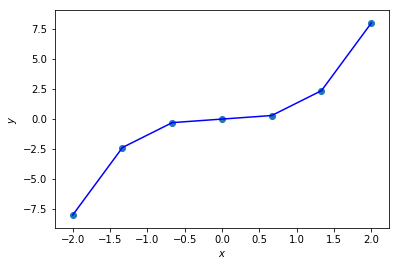

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3
X = X.reshape((7, 1))

plt.plot(X, y, "b")
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

In [3]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(max_depth=5,random_state=17)
reg_tree.fit(X, y);

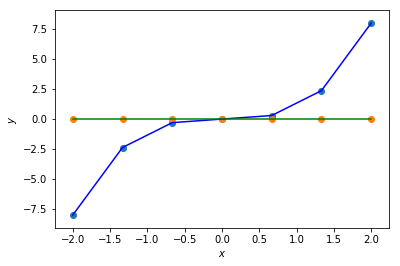

In [4]:
y0=[np.round(np.mean(y),decimals=3) for _ in range(0,7)]
plt.plot(X, y, "b")
plt.scatter(X, y)
plt.plot(X, y0, "g")
plt.scatter(X, y0)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');


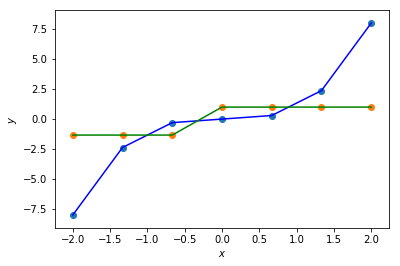

In [5]:
y1=[]
for x in X:
    if(x<0):
        y1.append(np.mean(list(filter(lambda x: x < 0, X))))
    else:
        y1.append(np.mean(list(filter(lambda x: x >= 0, X))))
plt.plot(X, y, "b")
plt.scatter(X, y)
plt.plot(X, y1, "g")
plt.scatter(X, y1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

In [6]:
def D(X,y):
    ret=0
    for i,_ in enumerate(X):
        ret+=(y[i]-(1/len(X))*sum(y)) ** 2 
    return ret/len(x)

D(X,y)

139.41289437585732

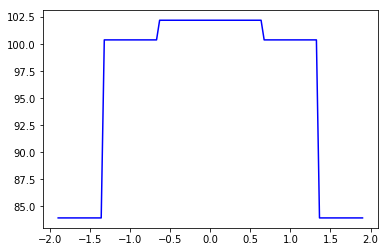

In [7]:
def regression_var_criterion(X, y, t):
    Xl=[]
    Yl=[]
    Xr=[]
    Yr=[]
    for i,_ in enumerate(X):
        if(X[i]<t):
            Xl.append(X[i])
            Yl.append(y[i])
        else:
            Xr.append(X[i])
            Yr.append(y[i])
    return D(X,y)-(len(Xl)/len(X))*D(Xl,Yl)-(len(Xr)/len(X))*D(Xr,Yr)
    

t=np.linspace(-1.9, 1.9, 100)
Q=[]
for tt in t:
    Q.append(regression_var_criterion(X, y, tt))
plt.plot(t, Q, "b")


## Вопрос 1 .
Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога t=0?

### ДА

[-2.0,
 -1.0,
 -1.0,
 0.66666666666666652,
 0.66666666666666652,
 0.66666666666666652,
 2.0]

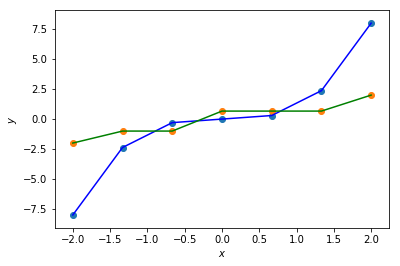

In [8]:
y2=[]
for x in X:
    if(x<0):
        if(x<-1.5):
            y2.append(np.mean(list(filter(lambda x: x < 0 and x < -1.5, X))))
        else:
            y2.append(np.mean(list(filter(lambda x: x < 0 and x >= -1.5, X))))
    else:
        if(x<1.5):
            y2.append(np.mean(list(filter(lambda x: x >= 0 and x < 1.5, X))))
        else:
            y2.append(np.mean(list(filter(lambda x: x >= 0 and x >= 1.5, X))))

plt.plot(X, y, "b")
plt.scatter(X, y)
plt.plot(X, y2, "g")
plt.scatter(X, y2)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');
y2

## Вопрос 2. 
Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?
### 5

In [9]:
df = pd.read_csv('../../../avysotsk/PycharmProjects/mlcourse/data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [10]:
df['age_years']=(df['age']// 365.25).astype(int)

In [11]:
X = pd.concat([df, pd.get_dummies(df['cholesterol'], prefix='cholesterol'),pd.get_dummies(df['gluc'], prefix='gluc') ], axis=1,verify_integrity=True)
y=X['cardio']
X.drop(['cardio'], axis=1, inplace=True)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)


In [13]:
first_tree = DecisionTreeClassifier(max_depth=3,random_state=17).fit(X_train, y_train)

In [14]:
export_graphviz(first_tree, out_file='cardio_tree.dot', feature_names=X.columns, filled=True)

In [15]:
!dot -Tpng cardio_tree.dot -o cardio_tree.png

<img src='cardio_tree.png'>

## Вопрос 3. 
Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")
### age, ap_hi, chol=3


In [16]:
tree_valid = first_tree.predict(X_valid)
accuracy_score(y_valid, tree_valid)

0.72128571428571431

In [17]:
tree_params = {'max_depth': list(range(2, 11))}
tree_grid = GridSearchCV(first_tree, tree_params, cv=5, n_jobs=-1)

In [18]:
%%time
tree_grid.fit(X_train, y_train)

Wall time: 30.1 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

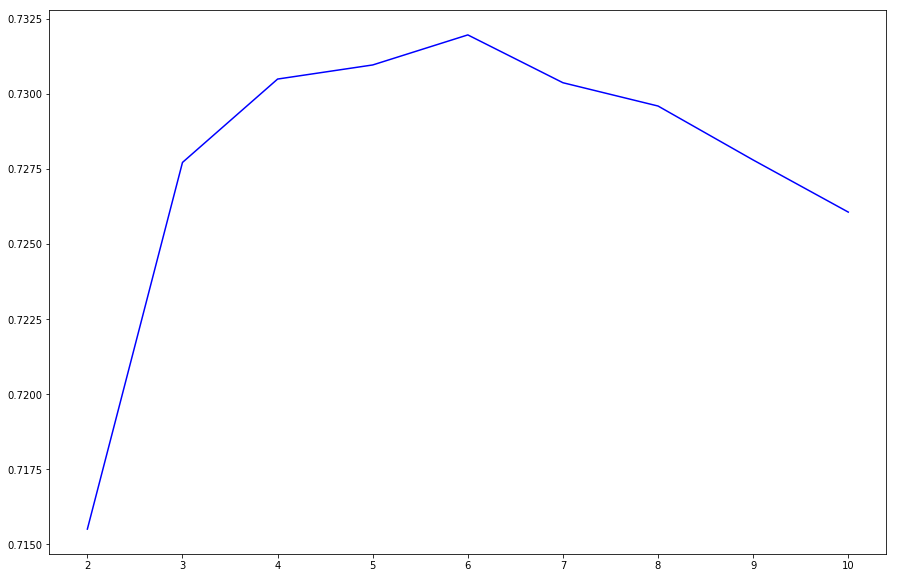

In [19]:
plt.figure(figsize=(15,10))
plt.plot(list(range(2, 11)), tree_grid.cv_results_ ['mean_test_score'], "b") 


In [20]:
tree_grid.best_score_, tree_grid.best_params_

(0.73195918367346935, {'max_depth': 6})

In [21]:
second_tree = DecisionTreeClassifier(max_depth=6,random_state=17).fit(X_train, y_train)
second_tree_valid = second_tree.predict(X_valid)
accuracy_score(y_valid, second_tree_valid)

0.72585714285714287

In [22]:
(0.72585714285714287 - 0.72128571428571431)*100

0.45714285714285596

## Вопрос 4. 
Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать max_depth от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?
### да, нет 

In [23]:
def age_category(age):
    if age < 45:
        return 0
    elif age < 50:
        return 1
    elif age < 55:
        return 2
    elif age < 60:
        return 3
    elif age < 65:
        return 4
    else:
        return 5

def ap_hi_category(ap_hi):
    if ap_hi < 120:
        return 0
    elif ap_hi < 140:
        return 1
    elif ap_hi < 160:
        return 2
    elif ap_hi < 180:
        return 3
    else:
        return 4    

In [24]:
X_copy=X

In [26]:
#X.drop('age_norm',axis=1,inplace=True)
#X.drop('ahi_norm',axis=1,inplace=True)
X['age_norm']=[age_category(age) for age in X['age_years']]
X['ahi_norm']=[ap_hi_category(ap_hi) for ap_hi in X['ap_hi']]

In [27]:
#X.drop('age_norm_1',axis=1,inplace=True)
#X.drop('age_norm_2',axis=1,inplace=True)
#X.drop('age_norm_3',axis=1,inplace=True)
#X.drop('age_norm_4',axis=1,inplace=True)
#X.drop('age_norm_0',axis=1,inplace=True)
X = pd.concat([X, pd.get_dummies(X['age_norm'], prefix='age_norm')], axis=1,verify_integrity=True)
#X.drop('ahi_norm_0',axis=1,inplace=True)
#X.drop('ahi_norm_1',axis=1,inplace=True)
#X.drop('ahi_norm_2',axis=1,inplace=True)
#X.drop('ahi_norm_3',axis=1,inplace=True)
#X.drop('ahi_norm_4',axis=1,inplace=True)
X = pd.concat([X, pd.get_dummies(X['ahi_norm'], prefix='ahi_norm')], axis=1,verify_integrity=True)


In [29]:
X['gender'] = X['gender'].map({2 : 1, 1 : 0})

,age_norm_1,age_norm_2,age_norm_3,age_norm_4,cholesterol_1,cholesterol_2,cholesterol_3,ahi_norm_1,ahi_norm_2,ahi_norm_3,smoke,gender
id,,,,,,,,,,,,
0,0,1,0,0,1,0,0,0,0,0,0,1
1,0,0,1,0,0,0,1,0,1,0,0,0
2,0,1,0,0,0,0,1,1,0,0,0,0
3,1,0,0,0,1,0,0,0,1,0,0,1
4,1,0,0,0,1,0,0,0,0,0,0,0


In [30]:
X.rename(columns={'gender':'male'}, inplace=True)

In [35]:
XX=X[['age_norm_1','age_norm_2','age_norm_3','age_norm_4',
      'cholesterol_1','cholesterol_2','cholesterol_3',
      'ahi_norm_1','ahi_norm_2','ahi_norm_3','smoke','male']]


In [36]:
third_tree = DecisionTreeClassifier(max_depth=3,random_state=17).fit(XX, y)


In [37]:
export_graphviz(third_tree, out_file='third_tree.dot', feature_names=XX.columns, filled=True)

In [38]:
!dot -Tpng third_tree.dot -o third_tree.png

<img src="third_tree.png">

## Вопрос 5. 
Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?

### Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
